# Deep Generative Models - Practical for AI in Medicine II


Date: 04.06.2024

Submission deadline: *18.06.2024*

For questions please contact: cosmin.bercea@tum.de

Please go through the notebook to:

i). complete the tasks marked with **T** (n=4) and

ii). answer the questions marked with **Q** (n=5).


## Overview

In this practical, you will explore the use of generative models for analyzing brain MRI scans.
Generative models can learn the underlying probability distribution of brain MRI data and generate new synthetic images that could plausibly represent real scans.
This has applications in generating training data, modeling disease progression, and detecting anomalies.


## Data

You will be working with the following datasets:

- Brain MRI scans of normal subjects from the IXI dataset
- Brain MRI scans of stroke patients with lesions from the ATLAS dataset

The data consists of mid-axial slice images from the MRI volumes.


## Tasks

- **Section 2.** VAEs (30 points)
- **Section 3.** GANs (30 points)
- **Section 4.** Diffusion Models (40 points)
- **Bonus.** Vision-Language Generative Models (10 points)

## Tools

You will use the following tools/libraries:

- PyTorch
- models/vae.py #Variational Autoencoders (VAEs)
- models/gans.py #Generative Adversarial Networks (GANs)
- models/diffusion.py #Diffusion Models (using a library like PyTorch Diffusion)
- Data loaders for loading and preprocessing the MRI data

## Deliverables

1. **A report (pdf)** describing your approaches, results, and findings for each of the three tasks, including sample outputs like generated images, data samples, visualizations etc.
2. **Code** for training your generative models and applying them to the given tasks.


## 0. Setup

Our team:

*   Mohammed Elbushnaq  – 03786474 – go56cuh
*   Marina Aoki – 03773384 – ge94naz
*   Sama Elbaroudy – 03768259 – ge83muj
*   Sarah Berbuir – 03767700 – ge83cak



In [2]:
!rm -rf *
# Clone the repository
!git clone https://github.com/compai-lab/aim_generative_practical_24.git
# Move all content to the current directory
!mv ./aim_generative_practical_24/* ./
# Remove the empty directory
!rm -rf aim_generative_practical_24/
!ls

Cloning into 'aim_generative_practical_24'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 38 (delta 4), reused 33 (delta 2), pack-reused 0
Receiving objects: 100% (38/38), 10.32 MiB | 39.29 MiB/s, done.
Resolving deltas: 100% (4/4), done.
configs		diff.gif     main_generative.ipynb  README.md
data_loader.py	evaluate.py  model		    requirements.txt


In [3]:
## Please uncomment this line only when running on Google Colab
!pip install pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.6 MB/s eta 0:00:00


In [4]:
# Install packages
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml
import numpy as np

from data_loader import TrainDataModule, get_all_test_dataloaders

# autoreload imported modules
%load_ext autoreload
%autoreload 2

/content/data_loader.py:108: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  self.pos_mask_paths = pd.read_csv(pos_mask_csv)['filename'].tolist() if pos_mask_csv is not 'None' else self.img_paths
/content/data_loader.py:109: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  self.neg_mask_paths = pd.read_csv(neg_mask_csv)['filename'].tolist() if neg_mask_csv is not 'None' else self.img_paths


In [5]:
with open('./configs/train_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config['seed'])

INFO:lightning_fabric.utilities.seed:Seed set to 3105


3105

## 1. Understanding the data

In [6]:
# # Download the data
!wget https://syncandshare.lrz.de/dl/fiX9T1xE1eV9kKDHJ4jMUu/brain_data.zip -P ./
# # Extract the data
!unzip -q ./brain_data.zip -d ./

--2024-06-18 13:25:32--  https://syncandshare.lrz.de/dl/fiX9T1xE1eV9kKDHJ4jMUu/brain_data.zip
Resolving syncandshare.lrz.de (syncandshare.lrz.de)... 129.187.255.213
Connecting to syncandshare.lrz.de (syncandshare.lrz.de)|129.187.255.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25644476 (24M) [application/x-zip-compressed]
Saving to: ‘./brain_data.zip’

brain_data.zip      100%[===================>]  24.46M   421KB/s    in 61s     

2024-06-18 13:26:34 (409 KB/s) - ‘./brain_data.zip’ saved [25644476/25644476]



### 1.1. Load and visualize the *healthy* data

In [7]:
config

{'seed': 3105,
 'train_data_healthy': './brain/ixi',
 'train_data_stroke': './brain/atlas/test',
 'split_dir': './data/splits',
 'target_size': [128, 128],
 'batch_size': 32,
 'latent_dim': 64,
 'num_epochs': 200,
 'lr': 0.0002}

Found 582 files in ./brain/ixi
Using 465 images for training and 117 images for validation
Batch shape: torch.Size([32, 1, 128, 128])
Batch min: 0.0
Batch max: 1.0


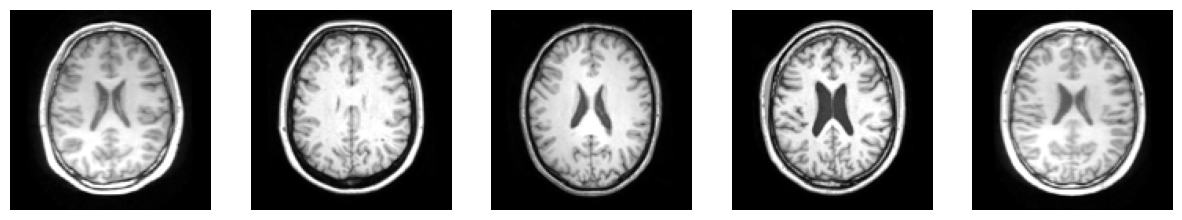

In [8]:
train_data_module_healthy = TrainDataModule(
    data_dir=config['train_data_healthy'],
    target_size=config['target_size'],
    batch_size=config['batch_size'])

# Plot some images
batch = next(iter(train_data_module_healthy.train_dataloader()))

# Print statistics
print(f"Batch shape: {batch.shape}")
print(f"Batch min: {batch.min()}")
print(f"Batch max: {batch.max()}")

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax[i].imshow(batch[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

### 1.2. Load and visualize the *pathology* data (Stroke)

Found 300 files in ./brain/atlas/test
Using 240 images for training and 60 images for validation
Batch shape: torch.Size([32, 1, 128, 128])
Batch min: 0.0
Batch max: 1.0


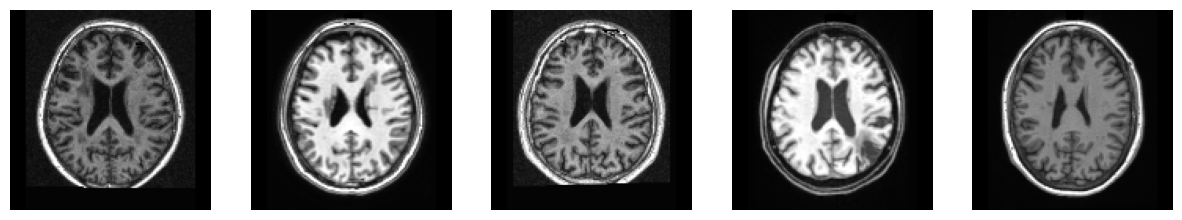

In [9]:
train_data_module_stroke = TrainDataModule(
    data_dir=config['train_data_stroke'],
    target_size=config['target_size'],
    batch_size=config['batch_size'])

# Plot some images
batch = next(iter(train_data_module_stroke.train_dataloader()))

# Print statistics
print(f"Batch shape: {batch.shape}")
print(f"Batch min: {batch.min()}")
print(f"Batch max: {batch.max()}")

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax[i].imshow(batch[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

## 2. Understanding VAEs
**Variational Autoencoders (VAEs)** consist of:
- An **encoder** that maps input images to a latent space.
- A **decoder** that reconstructs images from the latent space.

They are trained to minimize:
- The **reconstruction error**.
- The **Kullback-Leibler (KL) divergence** between the learned latent distribution and a prior distribution.

#### Why VAEs?
VAEs are useful for:
- **Image synthesis**: Generating new images similar to the training data.
- **Anomaly detection**: Identifying unusual patterns by reconstructing normal images.

#### Key Concepts
- **Latent space**: A compressed representation of input data.
- **KL divergence**: A measure of how one probability distribution differs from a second, expected probability distribution.



### [10 points] ----------------------------------------- T1 (VAE) -----------------------------------------
Implement the missing lines marked by `[TODO]` in **model/vae.py**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
# We added this to code of vae.py for simplicity to just upload jupyter notebook also a screenshot is attached in the report
# reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')
# kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


In [11]:
input_dim = config['target_size']  # Example input dimensions
latent_dim = config['latent_dim']
num_epochs = config['num_epochs']

In [ ]:
from model.vae import VAELightning
# Initialize the VAE model
input_dim = config['target_size']  # Example input dimensions
latent_dim = config['latent_dim']
num_epochs = config['num_epochs']

vae_model_healthy = VAELightning([1,input_dim[0],input_dim[1]], latent_dim)
vae_model_stroke = VAELightning([1,input_dim[0],input_dim[1]], latent_dim)

# Set up the trainer
trainer_healthy = pl.Trainer(max_epochs=num_epochs)  # Adjust trainer parameters as needed
trainer_stroke = pl.Trainer(max_epochs=num_epochs)  # Adjust trainer parameters as needed

# Start training
trainer_healthy.fit(vae_model_healthy, train_data_module_healthy.train_dataloader(), train_data_module_healthy.val_dataloader())
trainer_stroke.fit(vae_model_stroke, train_data_module_stroke.train_dataloader(), train_data_module_stroke.val_dataloader())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type            | Params | Mode 
-------------------------------------------------------
0  | conv1     | Conv2d          | 320    | train
1  | conv2     | Conv2d          | 18.5 K |

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type            | Params | Mode 
-------------------------------------------------------
0  | conv1     | Conv2d          | 320    | train
1  | conv2     | Conv2d          | 18.5 K | train
2  | conv3     | Conv2d          | 73.9 K | train
3  | fc1       | Linear          | 8.4 M  | train
4  | fc_mu     | Linear          | 16.4 K | train
5  | fc_logvar | Linear          | 16.4 K | train
6  | fc2       | Linear          | 16.6 K | train
7  | fc3       | Linear          | 8.4 M  | train
8  | conv4     | ConvTranspose2d | 73.8 K | train
9  | conv5     | ConvTranspose2d | 18.5 K

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


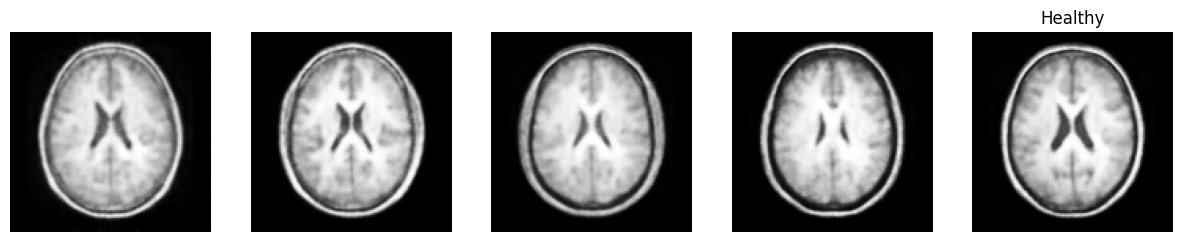

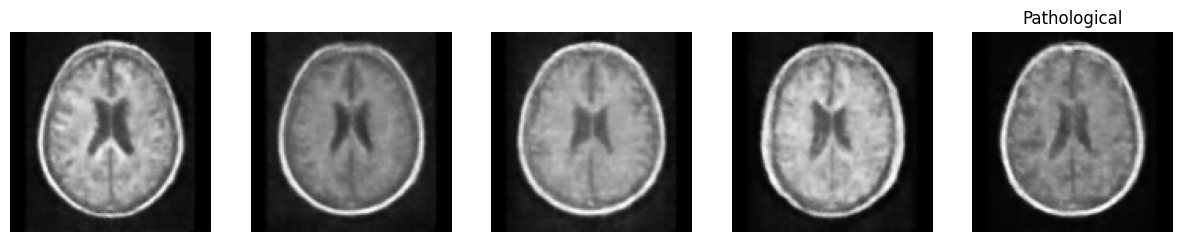

In [ ]:
# Generate random samples
vae_model_healthy.eval()
vae_model_stroke.eval()
with torch.no_grad():
    random_healthy_samples = vae_model_healthy.decode(torch.randn(16, latent_dim)).cpu().numpy()
    random_stroke_samples = vae_model_stroke.decode(torch.randn(16, latent_dim)).cpu().numpy()

# Plot the random samples
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
plt.title('Healthy')
for i in range(5):
    ax[i].imshow(random_healthy_samples[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
plt.title('Pathological')
for i in range(5):
    ax[i].imshow(random_stroke_samples[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

### [10 points] ----------------------------------------- Q1 (VAE) -----------------------------------------
Describe the quality of the generated images from the VAE model. Are there any noticeable differences between the healthy and pathological (stroke lesion) cases? Provide possible reasons for the observed similarities or differences.

### [10 points] ----------------------------------------- Q2 (VAE) -----------------------------------------
Suggest potential ways to improve the quality and diversity of the generated images, particularly for the pathological cases.

## 3. Understanding GANs

*Generative Adversarial Networks (GANs)* consist of:

- **A Generator:** This network generates new data instances that resemble the training data.
- **A Discriminator:** This network evaluates the authenticity of the generated data, distinguishing between real and fake data.

They are trained to minimize:
- The Generator's loss: Encourages the generator to produce data that the *discriminator cannot distinguish* from real data.
- The Discriminator's loss: Encourages the discriminator to accurately *classify real and fake* data.

**Why GANs?**
GANs are useful for:
- **Image synthesis:** Creating realistic images that are indistinguishable from real images.
- **Data augmentation:** Generating additional training data to improve the performance of machine learning models.
- **Style transfer:** Applying the style of one image to the content of another.

**Key Concepts**
- **Adversarial training:** A training process where the generator and discriminator compete against each other, improving their performance iteratively.
- **Latent space:** A compressed representation from which the generator creates new data instances.
- **Mode collapse:** A common issue where the generator produces limited varieties of outputs, failing to capture the diversity of the training data.


In [12]:
from model.wgan import GANModule
# Initialize the GAN model
hparams = {
    'image_size': input_dim[1],
    'latent_dim': latent_dim,
    'channels': 1,
    'lr': 0.0002,
    'n_critic': 1
}

In [13]:
from model.wgan import GANModule
# Initialize the GAN model
hparams = {
    'image_size': input_dim[1],
    'latent_dim': latent_dim,
    'channels': 1,
    'lr': 0.0002,
    'n_critic': 1
}
gan_model_healthy = GANModule(hparams)

# Set up the trainer
trainer_healthy = pl.Trainer(max_epochs= 800) # num_epochs)  # Adjust trainer parameters as needed

# Start training
trainer_healthy.fit(gan_model_healthy, train_data_module_healthy.train_dataloader(), train_data_module_healthy.val_dataloader())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | WGAN | 8.8 M  | train
---------------------------------------
8.8 M     Trainable params
0         Non-trainable params
8.8 M     Total params
35.392    Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=800` reached.


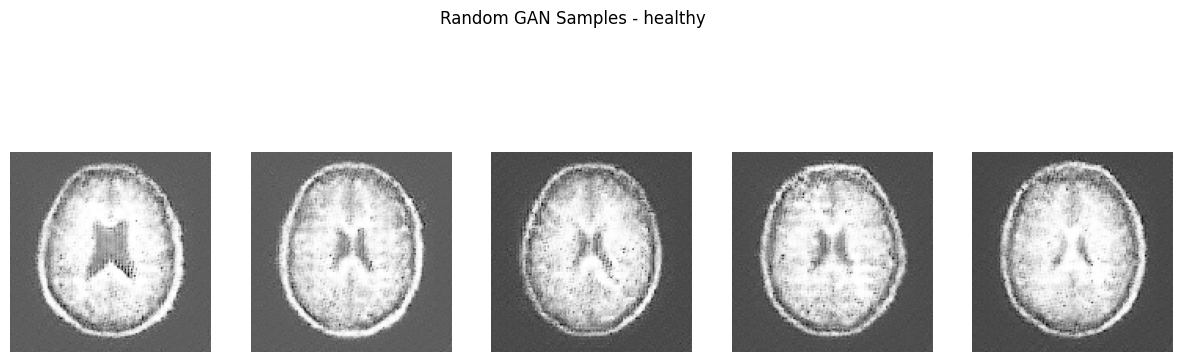

In [14]:
# Generate random samples
gan_model_healthy.eval()
with torch.no_grad():
    random_samples = gan_model_healthy(torch.randn(16, latent_dim)).cpu().numpy()

# Plot the random samples
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle('Random GAN Samples - healthy')
for i in range(5):
    sample_img = random_samples[i]
    ax[i].imshow(np.squeeze(sample_img), cmap='gray')
    ax[i].axis('off')
plt.show()

### [10 points] ----------------------------------------- Q3 (GAN) -----------------------------------------
Describe the quality of the generated brain MRI images from the GAN model. How do they compare to the real images in terms of realism and diversity? How do they compare to VAEs?

In [15]:
gan_model_stroke = GANModule(hparams)

# Set up the trainer
trainer_stroke = pl.Trainer(max_epochs=800) #num_epochs)  # Adjust trainer parameters as needed

# Start training
trainer_stroke.fit(gan_model_stroke, train_data_module_stroke.train_dataloader(), train_data_module_stroke.val_dataloader())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | WGAN | 8.8 M  | train
---------------------------------------
8.8 M     Trainable params
0         Non-trainable params
8.8 M     Total params
35.392    Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_e

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=800` reached.


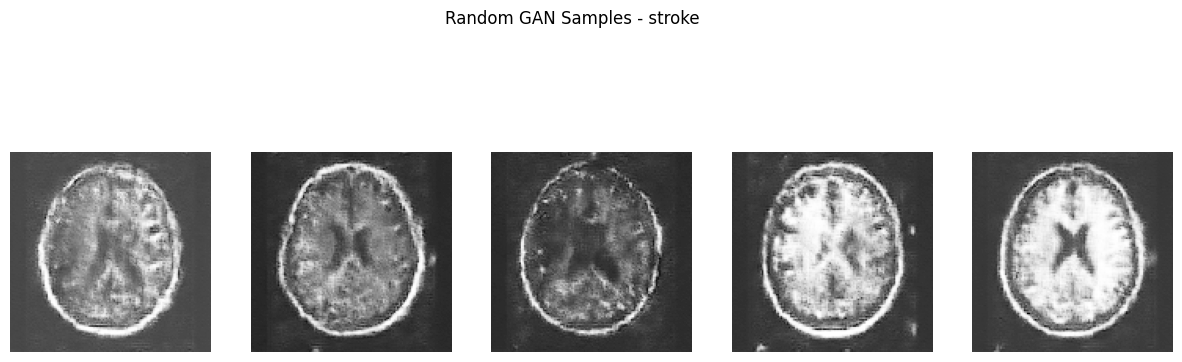

In [16]:
# Generate random samples
gan_model_stroke.eval()
with torch.no_grad():
    random_samples = gan_model_stroke(torch.randn(16, latent_dim)).cpu().numpy()

# Plot the random samples
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle('Random GAN Samples - stroke')
for i in range(5):
    sample_img = random_samples[i]
    ax[i].imshow(np.squeeze(sample_img), cmap='gray')
    ax[i].axis('off')
plt.show()

### [5 points] ----------------------------------------- Q4 (GAN) -----------------------------------------
 How can me measure the quality of the reconstruction for GANs? Implement a metric and compare the similarity to the pathological and healthy test sets.

### [15 points] ----------------------------------------- T2 (GAN) -----------------------------------------
Implement a metric and compare the similarity to the pathological and healthy test sets. (Hint: The metric should evaluate the closeness of two distributions)

In [17]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.applications.inception_v3 import InceptionV3
from numpy import asarray
from keras.applications.inception_v3 import preprocess_input
from scipy.linalg import svd


In [18]:
def create_real_img(dataloader, type):
    real_img = np.array([j for i in dataloader for j in i])
    print("Shape of real_img:", real_img.shape)

    real_img = np.transpose(real_img, (0, 2, 3, 1))
    print("Shape after transpose:", real_img.shape)

    real_img = np.concatenate([real_img]*3, axis=-1)
    print("Shape after reshape:", real_img.shape)
    real_img = real_img.astype('float32')

    fig, ax = plt.subplots(1, 5, figsize=(5, 2))
    fig.suptitle(f'{type} & real GAN-generated Images')
    for j in range(5):
      ax[j].imshow(real_img[j], cmap='gray')
      ax[j].axis('off')
    plt.show()
    return real_img

In [19]:
def create_fake_img(gan_model, len_real_img, type):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    gan_model.to(device)
    gan_model.eval()
    with torch.no_grad():
        generated_img = gan_model(torch.randn(len_real_img, latent_dim, device=device)).cpu().numpy()
    generated_img = np.array(generated_img)
    print("Shape of generated_img:", generated_img.shape)
    generated_img = np.transpose(generated_img, (0, 2, 3, 1))
    print("Shape after transpose:", generated_img.shape)
    generated_img = np.concatenate([generated_img]*3, axis=-1)

    print("Shape after reshape:", generated_img.shape)
    generated_img = generated_img.astype('float32')

    fig, ax = plt.subplots(1, 5, figsize=(5, 2))
    fig.suptitle(f'{type} & fake GAN-generated Images')
    for j in range(5):
      ax[j].imshow(generated_img[j], cmap='gray')
      ax[j].axis('off')
    plt.show()
    return generated_img

In [20]:
model = InceptionV3(include_top=False,
                              weights="imagenet",
                              pooling='avg')

87910968/87910968 [==============================] - 0s 0us/step


In [21]:
def calculate_fid(model, images1, images2):
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # print(np.allclose(act1, act2, atol=1e-6))
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # print(np.allclose(mu1, mu2, atol=1e-6))
    # print(np.allclose(sigma1, sigma2, atol=1e-6))
    # calculate sum squared difference between means
    ssdiff = (mu1.T - mu2)**2.0
    # print(np.all(ssdiff == 0.0))
    ssdiff = np.sum(ssdiff)
    cov_prod = sigma1.dot(sigma2)
    U, S, Vt = svd(cov_prod)
    covmean = U.dot(np.diag(np.sqrt(S))).dot(Vt)

    if iscomplexobj(covmean):
      covmean = covmean.real

    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

**Test real healthy images against generated ones**

Shape of real_img: (117, 1, 128, 128)
Shape after transpose: (117, 128, 128, 1)
Shape after reshape: (117, 128, 128, 3)


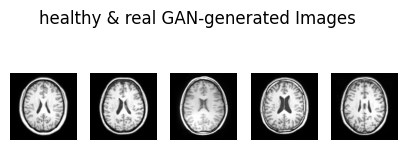

Shape of generated_img: (117, 1, 128, 128)
Shape after transpose: (117, 128, 128, 1)
Shape after reshape: (117, 128, 128, 3)


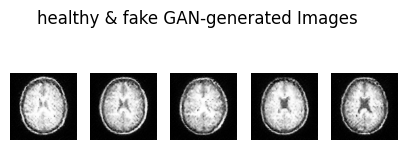

Preprocessed (117, 128, 128, 3) (117, 128, 128, 3)


In [22]:
real_img_healthy = create_real_img(train_data_module_healthy.val_dataloader(), "healthy")
generated_img_healthy = create_fake_img(gan_model_healthy, len(real_img_healthy), "healthy")

generated_img_healthy = preprocess_input(generated_img_healthy)
real_img_healthy = preprocess_input(real_img_healthy)
print('Preprocessed', generated_img_healthy.shape, real_img_healthy.shape)

In [23]:
fid = calculate_fid(model, real_img_healthy, real_img_healthy)
print('FID healthy same for testing: %.3f' % fid)
fid = calculate_fid(model, real_img_healthy, generated_img_healthy)
print('FID healthy real - generated: %.3f' % fid)

4/4 [==============================] - 0s 36ms/step
FID healthy same for testing: -0.000
4/4 [==============================] - 0s 24ms/step
FID healthy real - generated: 175.848


**Test real stroke images against generated ones**

Shape of real_img: (60, 1, 128, 128)
Shape after transpose: (60, 128, 128, 1)
Shape after reshape: (60, 128, 128, 3)


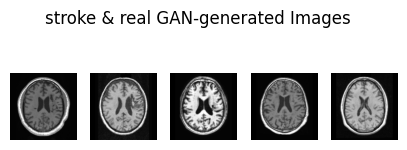

Shape of generated_img: (60, 1, 128, 128)
Shape after transpose: (60, 128, 128, 1)
Shape after reshape: (60, 128, 128, 3)


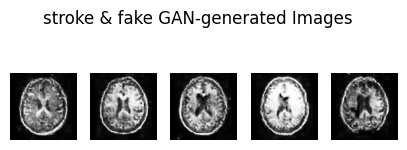

Preprocessed (60, 128, 128, 3) (60, 128, 128, 3)


In [24]:
real_img_stroke = create_real_img(train_data_module_stroke.val_dataloader(), "stroke")
generated_img_stroke = create_fake_img(gan_model_stroke, len(real_img_stroke), "stroke")

generated_img_stroke = preprocess_input(generated_img_stroke)
real_img_stroke = preprocess_input(real_img_stroke)
print('Preprocessed', generated_img_stroke.shape, real_img_stroke.shape)

In [25]:
fid = calculate_fid(model, real_img_stroke, real_img_stroke)
print('FID stroke same for testing: %.3f' % fid)
fid = calculate_fid(model, real_img_stroke, generated_img_stroke)
print('FID stroke real - generated: %.3f' % fid)

2/2 [==============================] - 0s 17ms/step
FID stroke same for testing: 0.000
2/2 [==============================] - 0s 37ms/step
FID stroke real - generated: 96.499


## 4. Understanding Diffusion Models

**Why Diffusion Models?**
Diffusion Models are useful for:
- **Image synthesis:** Generating new images that resemble the training data.
- **Image denoising:** Removing noise from images to restore their original quality.
- **Inpainting and super-resolution:** Filling in missing parts of images and enhancing image resolution.
- **Anomaly Detection:** Generating pseudo-normal samples by *partly* noising and denoising pathological images.

**Key Concepts**

- **Forward and Reverse Processes:** The forward process adds noise to the data, while the reverse process removes it.
- **Markov chain:** A sequence of steps where each step depends only on the previous one, used in both the forward and reverse processes.
- **Noise schedule:** A predefined sequence of noise levels added during the forward process, which the model learns to reverse.

Diffusion models are powerful generative models that have shown significant promise in various applications.



**Get trained model** (DDPM with Gaussian noise trained for 1500 epochs on healthy samples)

In [ ]:
!wget https://syncandshare.lrz.de/dl/fiGC15qSsdj1Tx7uojZvAT/latest_model.pt.zip # weights
!unzip -q latest_model.pt.zip

--2024-06-17 20:15:41--  https://syncandshare.lrz.de/dl/fiGC15qSsdj1Tx7uojZvAT/latest_model.pt.zip
Resolving syncandshare.lrz.de (syncandshare.lrz.de)... 129.187.255.213
Connecting to syncandshare.lrz.de (syncandshare.lrz.de)|129.187.255.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200797607 (191M) [application/x-zip-compressed]
Saving to: ‘latest_model.pt.zip’

latest_model.pt.zip 100%[===================>] 191.50M   592KB/s    in 5m 34s  

2024-06-17 20:21:16 (587 KB/s) - ‘latest_model.pt.zip’ saved [200797607/200797607]



### Load weights

In [ ]:
with open('./configs/diffusion_config.yaml', 'r') as f:
    diff_config = yaml.safe_load(f)

In [ ]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.0 MB/s eta 0:00:00


In [ ]:
from model.ddpm import DDPM

In [ ]:
diff_config

{'spatial_dims': 2,
 'in_channels': 1,
 'out_channels': 1,
 'num_channels': [128, 256, 256],
 'attention_levels': [False, True, True],
 'num_res_blocks': 1,
 'num_head_channels': 256,
 'train_scheduler': 'ddpm',
 'inference_scheduler': 'ddpm',
 'inference_steps': 1000,
 'noise_level': 300,
 'noise_type': 'gaussian',
 'prediction_type': 'epsilon'}

In [ ]:
#diff_config
anoddpm = DDPM(**diff_config)
anoddpm.to('cuda:0')

DDPM(
  (unet): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (skip_connection): Iden

In [ ]:
print(torch.cuda.device_count())

1


In [ ]:
# load weights
checkpoint = torch.load('latest_model.pt',map_location='cuda:0', weights_only=True)['model_weights']
anoddpm.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
t=200
x_, _ = anoddpm.sample_from_image(batch.to('cuda:0'), noise_level=t)

100%|██████████| 201/201 [04:42<00:00,  1.40s/it]


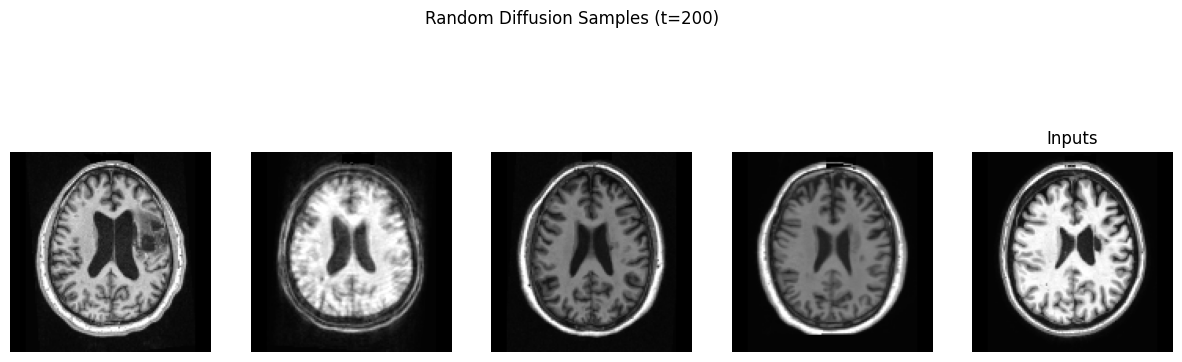

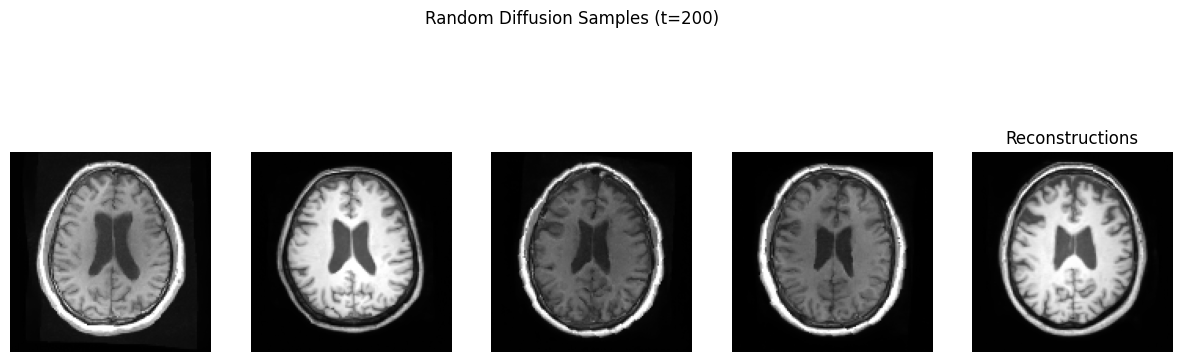

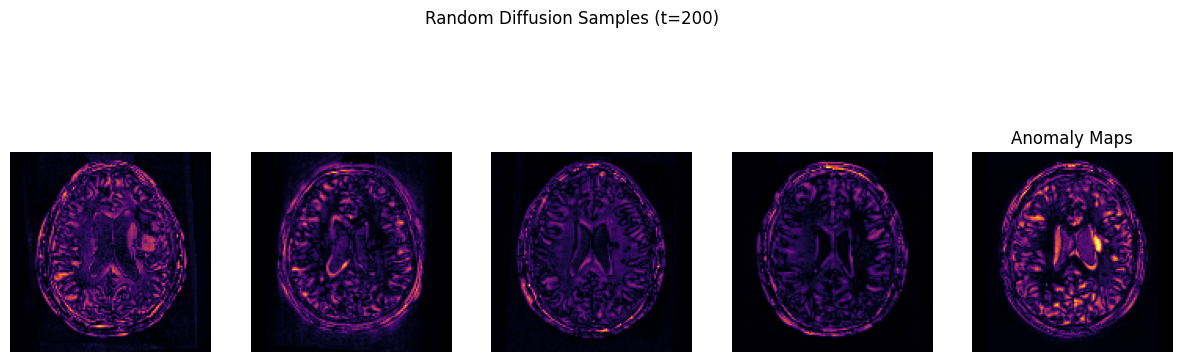

In [ ]:
# Input

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle('Random Diffusion Samples (t=200)')
plt.title('Inputs')
for i in range(5):
    sample_img = batch[i]
    ax[i].imshow(sample_img[0], cmap='gray')
    ax[i].axis('off')
plt.show()

# Recons
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle('Random Diffusion Samples (t=200)')
plt.title('Reconstructions')
for i in range(5):
    sample_img = x_[i].cpu().numpy()
    ax[i].imshow(sample_img[0], cmap='gray')
    ax[i].axis('off')
plt.show()

# Anomaly maps
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle('Random Diffusion Samples (t=200)')
plt.title('Anomaly Maps')
for i in range(5):
    sample_img = np.abs(batch[i] - x_[i].cpu().numpy())
    ax[i].imshow(sample_img[0], cmap='inferno')
    ax[i].axis('off')
plt.show()

### [10 points] ----------------------------------------- Q5 (Diffusion) -----------------------------------------
How does the anomaly detection performance vary with varying noise levels t? (Hint: Visually analyse the performance for different noise levels **t** (one batch is enough))

In [ ]:
t1=100
x_1, _ = anoddpm.sample_from_image(batch.to('cuda:0'), noise_level=t1)

t2=50
x_2, _ = anoddpm.sample_from_image(batch.to('cuda:0'), noise_level=t2)

t3=25
x_3, _ = anoddpm.sample_from_image(batch.to('cuda:0'), noise_level=t3)

t4 = 300
x_4, _ = anoddpm.sample_from_image(batch.to('cuda:0'), noise_level=t4)

t5 = 0
x_5 = anoddpm.sample_from_image(batch.to('cuda:0'), noise_level=t5)

100%|██████████| 1/1 [00:00<00:00, 53.88it/s]


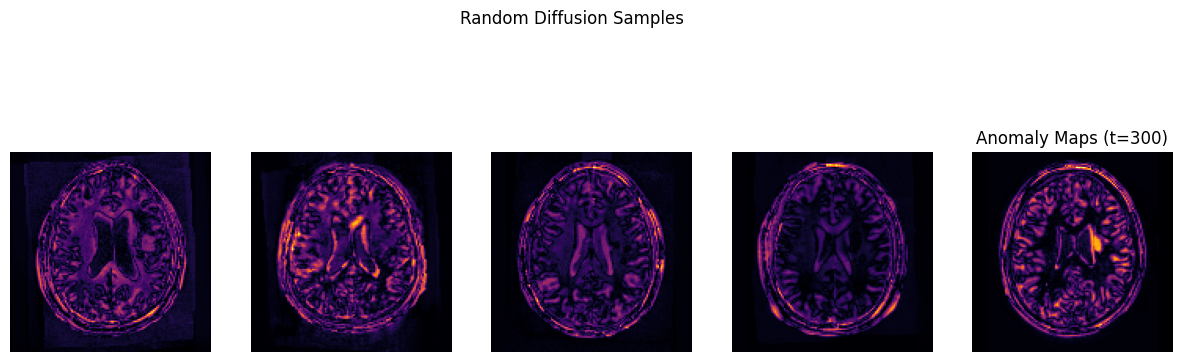

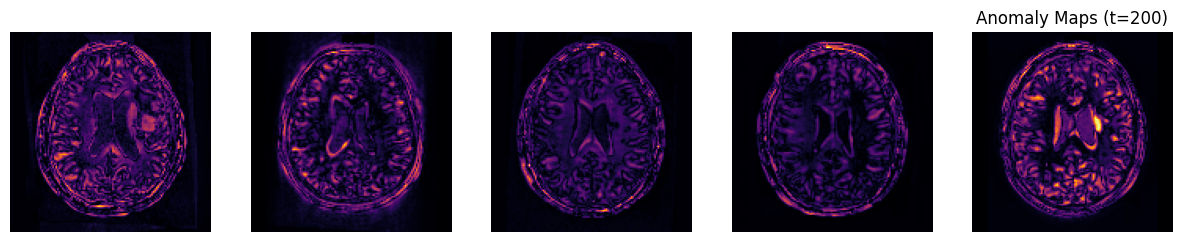

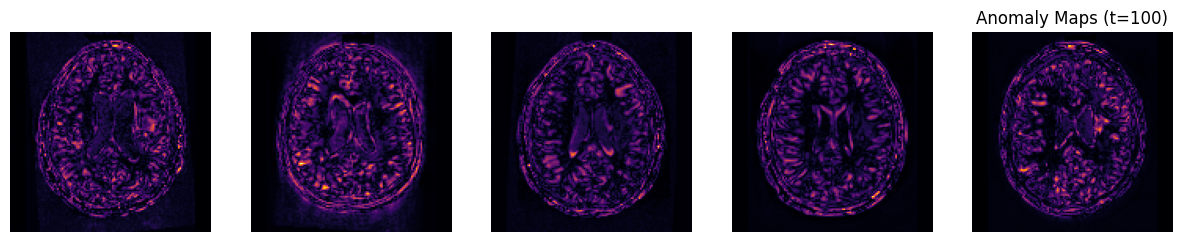

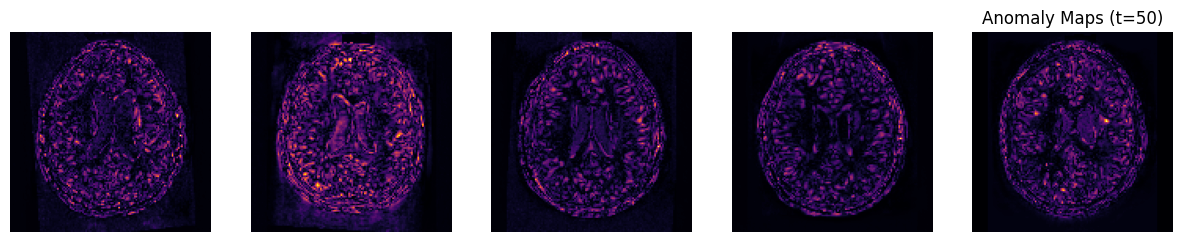

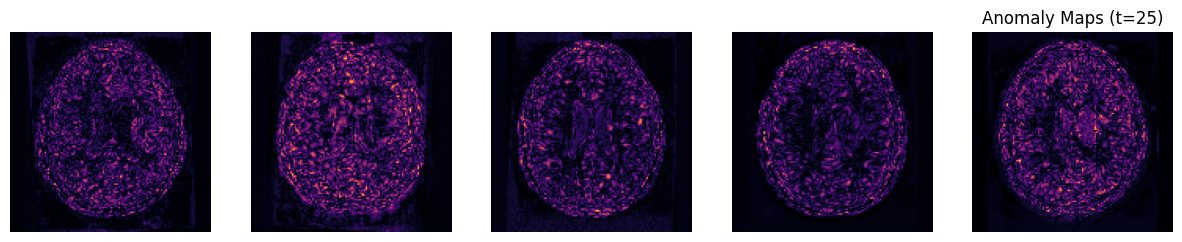

In [ ]:
# Anomaly maps for t=300
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle('Random Diffusion Samples')
plt.title('Anomaly Maps (t=300)')
for i in range(5):
    sample_img = np.abs(batch[i] - x_4[i].cpu().numpy())
    ax[i].imshow(sample_img[0], cmap='inferno')
    ax[i].axis('off')
plt.show()

# Anomaly maps for t=200
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
plt.title('Anomaly Maps (t=200)')
for i in range(5):
    sample_img = np.abs(batch[i] - x_[i].cpu().numpy())
    ax[i].imshow(sample_img[0], cmap='inferno')
    ax[i].axis('off')
plt.show()


# Anomaly maps for t=100
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
plt.title('Anomaly Maps (t=100)')
for i in range(5):
    sample_img = np.abs(batch[i] - x_1[i].cpu().numpy())
    ax[i].imshow(sample_img[0], cmap='inferno')
    ax[i].axis('off')
plt.show()

# Anomaly maps for t=50
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
plt.title('Anomaly Maps (t=50)')
for i in range(5):
    sample_img = np.abs(batch[i] - x_2[i].cpu().numpy())
    ax[i].imshow(sample_img[0], cmap='inferno')
    ax[i].axis('off')
plt.show()

# Anomaly maps for t=25
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
plt.title('Anomaly Maps (t=25)')
for i in range(5):
    sample_img = np.abs(batch[i] - x_3[i].cpu().numpy())
    ax[i].imshow(sample_img[0], cmap='inferno')
    ax[i].axis('off')
plt.show()

For larger values of t, the anomalies that are detected seem to capture more of the structures inherent to the input image. For lower values of t, the anomalies are scattered and do not seem to correspond to realistic brain anatomy.

### [10 points] ----------------------------------------- T3 (Diffusion) -----------------------------------------
Write a dataloader to load both images and ground truth masks in atlas/train/:

In [ ]:
from os import listdir
from os.path import isfile, join
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class BrainDataset(Dataset):

    def __init__(self, data_dir):
        """
        Loads both images and ground truth masks in atlas/train/

        @param data_dir:
            path to directory containing the images and ground truth masks
        """
        super(BrainDataset, self).__init__()

        # Read all the files in the directory
        self.data = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f))]
        # Get all the images and their ground truth masks as a list of tuples
        self.data = [(f, f.removesuffix(".png")+"_mask.png") for f in self.data if f.endswith(".png") and not f.endswith("_mask.png")]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, gt_name = self.data[idx]
        # Load image
        img = Image.open(img_name).convert('L')
        # Convert to tensor
        img = transforms.ToTensor()(img)
        # Load ground truth
        gt = Image.open(gt_name).convert('L')
        # Convert to tensor
        gt = transforms.ToTensor()(gt)
        return img, gt

brainloader = DataLoader(BrainDataset("./brain/atlas/train/"), shuffle=True)


In [ ]:
len(brainloader)

NameError: name 'brainloader' is not defined

### [20 points] ----------------------------------------- T4 (Diffusion) -----------------------------------------
Evaluate the diffusion models on the atlas/train dataset on pixel-wise localization. Implement therefore the Dice Score and report the mean and std for the dataset. You would therefore need to select a noise level **t**. (motivate selection based on Q5).  

In [ ]:
# Implement the Dice score for the given inputs
def dice_score(pred, target):
    # Flatten the inputs
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)

    # Compute the intersection
    intersection = (pred * target).sum(dim=1)

    # Compute the union
    union = pred.sum(dim=1) + target.sum(dim=1)

    # Compute the Dice score
    dice_score = 2 * intersection / union
    return dice_score

In [ ]:
# Evaluate the diffusion models on the brainloader

dice_scores = []
anoddpm.eval()

for img, gt in brainloader:
    img, gt = img.to('cuda:0'), gt.to('cuda:0')
    x, _ = anoddpm.sample_from_image(img, noise_level=200)
    dice = dice_score(x, gt)
    dice_scores.append(dice)

dice_scores = torch.cat(dice_scores)
mean_dice = dice_scores.mean().item()
std_dice = dice_scores.std().item()

print(f"Mean Dice score: {mean_dice:.4f}")
print(f"Std Dice score: {std_dice:.4f}")

  4%|▍         | 9/201 [00:00<00:08, 21.64it/s]

## 5. Bonus: Vision-Language Generative Models (VLMs)

VLMs consist of:
- **Image Encoder:** Transforms images into a latent representation.
- **Text Encoder:** Converts text descriptions into a corresponding latent representation.
- **Multimodal Fusion Module:** Aligns and integrates the visual and textual representations.
- **Text Decoder:** Generates text outputs based on the fused multimodal representation.

They are trained to minimize:
- **Cross-Modal Matching Loss:** Ensures that the visual and textual representations are aligned in the latent space.
- **Generation Loss:** Measures the accuracy of the generated text or image against the ground truth.

**Why Vision-Language Generative Models?**

*Applications and Challenges*
Vision-Language Generative Models have numerous applications, including creating visual content from text prompts, enhancing human-computer interaction through visual assistants, and improving accessibility with automatic image descriptions. However, challenges such as understanding spatial relationships, handling high-dimensional visual data, and ensuring the reliability of generated content remain active areas of research.

### [10 points] ----------------------------------------- Q6 (VLMs) -----------------------------------------
**Outline** how Vision-Language Generative Models can be used to generate samples. Consider the following aspects:

- *Training Process:* Describe the steps involved in training a VLG model, including data preparation, model architecture, and loss functions.
- *Generation Process:* Explain how the model generates new samples, whether text from images or images from text.
- *Applications:* Discuss potential applications of VLG models in real-world scenarios, such as automated content creation, visual question answering, and accessibility enhancements.
- *Challenges:* Identify and elaborate on the key challenges faced in developing and deploying VLG models, such as handling high-dimensional data and ensuring the accuracy and relevance of generated content.